In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "“backend" on line 1 in
/Users/kenfuliang/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Util

In [66]:
def get_key(dic,val): 
    rt = []
    for key, value in dic.items(): 
        if val == value:
            rt.append(key)
    return rt
def visualizePolicy(gridWidth, gridHeight, policy):
    patch=[]
    #grid height/width
    gridAdjust = 0.5
    gridScale = 1
    arrowScale = .2
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
#     plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
#     ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

    #goal and trap coloring 
#     ax.add_patch(Rectangle((goalState[0]-gridAdjust, goalState[1]-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    
#     for (trapx, trapy) in trapStates:
#         ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))

    # grid lines
#     for x in xs:
#         draw = plt.plot([x, x], [ys[0], ys[-1]], color = "black")
#         patch.append(draw)
#     for y in ys:
#         draw = plt.plot([xs[0], xs[-1]], [y, y], color = "black")
#         patch.append(draw)

    #labeled values
#     for (statex, statey), actionDict in policy.items():
#         for (optimalActionX, optimalActionY), actionProb in actionDict.items():
#             plt.arrow(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    
    for (state, action),actionProb in policy.items():
        statex,statey = state
        optimalActionX,optimalActionY = action
#         print(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale)
        if actionProb!=0:
            draw = plt.arrow(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    
            patch.append(draw)
    return patch

# Gridworld and MDP policy

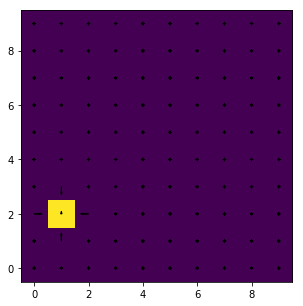

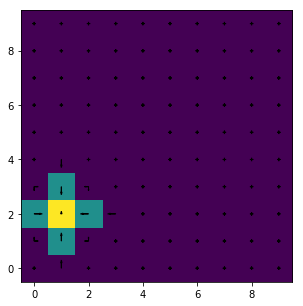

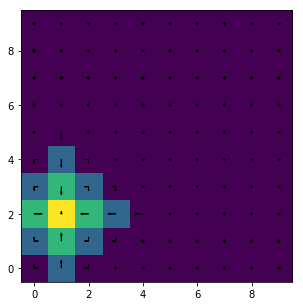

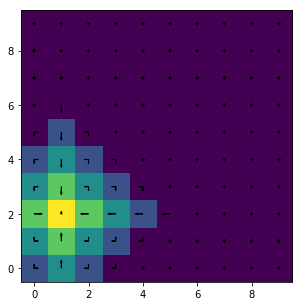

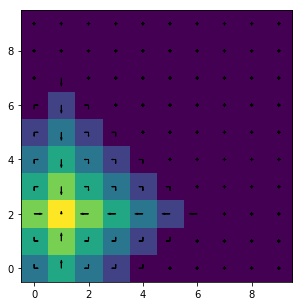

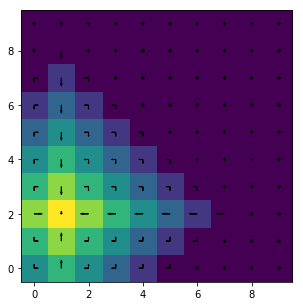

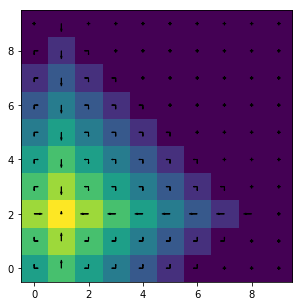

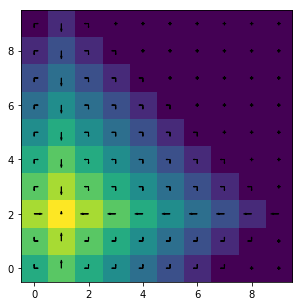

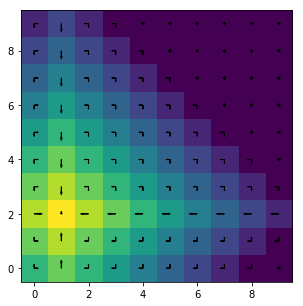

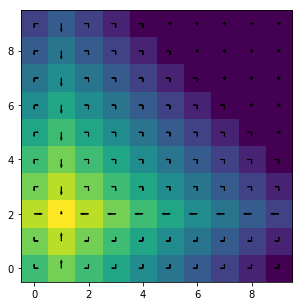

In [91]:
class GridWorld(object):
    def __init__(self,X=10,Y=10,stores=[]):
        # hyperparameters 
        self.X = X
        self.Y = Y
        self.error_prob = 0 # error probability in transition matrix 
        self.obstacles = []
        self.stores = stores if len(stores) else [tuple(np.random.randint((1,2),(self.X,self.Y)))]
        
        # expend to gridworld variables
        self.states = ([tuple((xx,yy)) for xx in range(self.X) for yy in range(self.Y)])
        self.actions = (tuple((0,-1)),tuple((0,1)),tuple((1,0)),tuple((-1,0)),tuple((0,0)))
        
    def transition(self,state,action):

        # init valid next_states
        rt = {}
        for a in self.actions:
            next_state = tuple(np.array(state)+np.array(a))
            if self._check_valid(next_state):
                rt[next_state]=0
        
        
        for a in self.actions:
            next_state = np.array(state)+np.array(action)
            next_state = tuple(next_state)
            if self._check_valid(next_state):
                if a == action:
                    rt[(next_state)]+=1-self.error_prob
                else:
                    rt[(next_state)]+=self.error_prob/len(self.actions)                
            else: #not valid -> stay the same state
                if a == action:
                    rt[(state)]+=1-self.error_prob
                else:
                    rt[(state)]+=self.error_prob/len(self.actions)  
        rt = [(prob,state) for (state,prob) in rt.items()]
#         print(rt)
        return rt

        
    def reward(self,state,action, next_state):
        if next_state in self.stores:
            if action == tuple((0,0)):
                return 1
        return 0
        
    def _check_valid(self,next_state):
        # check valid state, return true or false
#         print(next_state[0],next_state[1])
        rt = True
        if next_state[0]<0 or next_state[0]>=self.X:
            rt = rt and False
            
        if next_state[1]<0 or next_state[1]>=self.Y:
            rt = rt and False
        return rt
            
            
        

class MDPPolicy(object):
    def __init__(self,env,gamma=0.99):
        # given
        self.env = env  
        self.gamma = gamma
        # setting
        self.deterministic = True
        
        # want
        self.value = np.zeros((self.env.X, self.env.Y))
        self.policy = {(state,action): 1/len(self.env.actions) for state in self.env.states for action in self.env.actions}
    
    def train(self):
        self.value = self.ValueIteration(self.value)
        self.policy = self.PolicyIteration(self.value)
        
        return self.value, self.policy

    def ValueIteration(self,value):
        value_pre = value.copy()
        value_next = np.zeros_like(value_pre)
        for s in self.env.states:
            Q = {a: 0 for a in self.env.actions}
            for a in self.env.actions:
                for prob, next_state in self.env.transition(s,a):
                    Q[a] += prob* ( self.env.reward(s,a,next_state) + self.gamma*value_pre[next_state] )
            value_next[s] = max(Q.values())
        return value_next       
    
    def PolicyIteration(self,value):
        # init policy 
        policy = {(s,a):None for s in self.env.states for a in self.env.actions}
        for s in self.env.states:

            Q = {a: 0 for a in self.env.actions}
            for a in self.env.actions:  
                for prob, next_state in self.env.transition(s,a):
                    Q[a]+=prob*(value[next_state])

            if self.deterministic == True:
                optimal_actions = [action for action, value in Q.items() if value==max(Q.values())]
                for a in self.env.actions:
                    if a in optimal_actions:
                        policy[(s,a)] = 1/len(optimal_actions)
                    else:
                        policy[(s,a)] = 0
            else: # softmax
                Z = sum([np.exp(a) for a in self.env.actions])
                for a in self.env.actions:
                    policy[(s,a)] = np.exp(Q[a])/Z
        return policy
    
gridworld = GridWorld()
agent = MDPPolicy(env=gridworld)


for _ in range(10):
    value,policy = agent.train()
    fig=plt.figure(figsize=(5,5))
    ax = plt.axes(xlim=(-0.5, 9.5), ylim=(-0.5, 9.5))
    plt.imshow(value.T,origin='lower',)
    visualizePolicy(10,10,policy)
    plt.show()

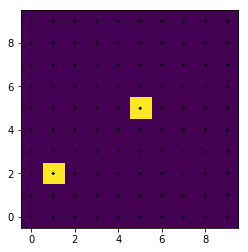

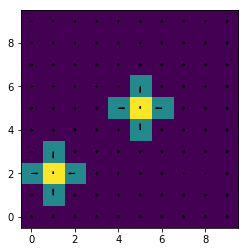

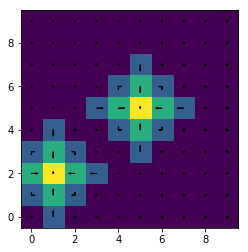

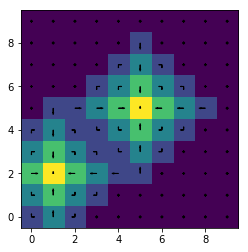

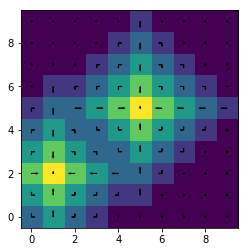

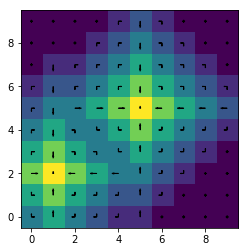

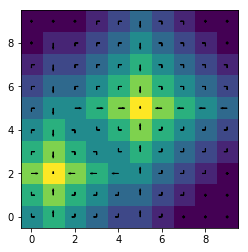

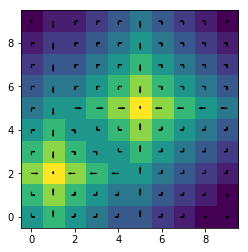

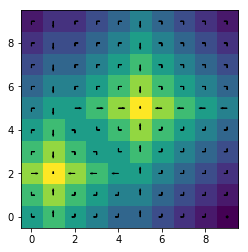

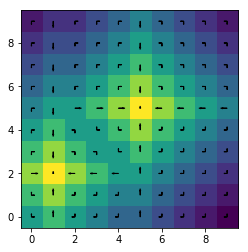

In [3]:
## basic grid world ice cream scearch 
## Define env
H_X, H_Y = 10,10 # map size
states = ([tuple((xx,yy)) for xx in range(H_X) for yy in range(H_Y)])
actions = (tuple((0,-1)),tuple((0,1)),tuple((1,0)),tuple((-1,0)),tuple((0,0)))
Store_D, Store_S = tuple((5,5)), tuple((1,2)) ## store position
gamma = 0.9

def TransitionP(s0,a0,correctProb=1):    
    s1 = np.array(s0)+np.array(a0)
    if(s1[0]<0 or s1[0]==H_X):
        s1[0] = s0[0]
    if(s1[1]<0 or s1[1]==H_Y):
        s1[1] = s0[1]
    return tuple(s1)


def rewardF(s0,a,s1):
    if (s1==Store_D and s0==Store_D) or (s1==Store_S and s0==Store_S):
        return 1
    else :
        return 0

def ValueIteration(value):
    value_pre = value.copy()
    value_next = np.zeros_like(value_pre)
    for s in states:
        Q = {a: 0 for a in actions}
        for a in actions:
            next_s = TransitionP(s,a)
            Q[a] = (rewardF(s,a,next_s) + gamma*value_pre[next_s])
        value_next[s] = max(Q.values())
    return value_next

def PolicyIteration(value):
    # init policy 
    policy = {(s,a):0 for s in states for a in actions}
    for s in states:
        max_value = -np.inf
        for a in actions:
            s1 = TransitionP(s,a) 
            max_value = max(max_value, value[s1])
            
        acts = []
        for a in actions:
            s1 = TransitionP(s,a) 
            if max_value == value[s1]:
                acts.append(a)
        for a in acts:
            policy[(s,a)] = 1/len(acts)
    return policy
    
def VisualizeValue(value):
    plt.imshow(value.T,origin='lower',)
#     plt.show()
    
def VisualizePolicy(policy):
    return 

# init value table 
value = np.zeros((H_X,H_Y))
value_history = []
policy_history = []
for _ in range(10):

    policy = PolicyIteration(value)
    value = ValueIteration(value) 
    visualizePolicy(10,10,Store_D,[0],policy)
    VisualizeValue(value)
    plt.show()
    value_history.append(value)
    policy_history.append(policy)


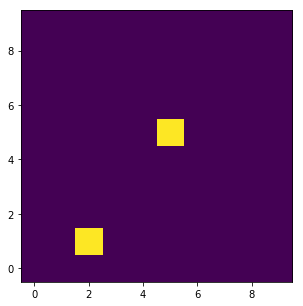

In [4]:
from matplotlib import animation
# %matplotlib qt
fig=plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(-0.5, 9.5), ylim=(-0.5, 9.5))
im = plt.imshow(np.zeros((10,10)))
# initialization function: plot the background of each frame
def init():
    im.set_data(value_history[0])
    return [im]

# animation function.  This is called sequentially
def animate(i):
    a=value_history[i]
    im.set_array(a)
    im.autoscale()
    
#     patch = plt.Arrow(0, 0,1,1)
#     ax.add_patch(patch)
#     patch = plt.Arrow(1, 1,2,1)
#     ax.add_patch(patch)
#     patch = visualizePolicy(10,10,Store_D,[0],policy_history[i])
#     for pp in patch:
#         ax.add_patch(pp)
    return [im]
anim = animation.FuncAnimation(fig, animate,
                               frames=10, interval=100, blit=True)

In [5]:
from IPython.display import HTML
HTML(anim.to_html5_video())